In [1]:
%matplotlib inline
import mindspore
import mindcv
from mindspore import nn
from d2l import mindspore as d2l

[WARNING] ME(39632:9184,MainProcess):2023-03-03-02:49:54.611.363 [mindspore\common\api.py:840] 'mindspore.ms_class' will be deprecated and removed in a future version. Please use 'mindspore.jit_class' instead.
[WARNING] ME(39632:9184,MainProcess):2023-03-03-02:49:54.656.244 [mindspore\common\api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(39632:9184,MainProcess):2023-03-03-02:49:54.658.239 [mindspore\common\api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.


### 13.1.1. 常用的图像增广方法

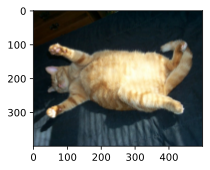

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    if isinstance(aug(img), tuple):
        # add [0] for the return of mindspore.Compose() is tuple
        Y = [aug(img)[0] for _ in range(num_rows * num_cols)]
    else:
        Y = [aug(img) for _ in range(num_rows * num_cols)]
    
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### 13.1.1.1. 翻转和裁剪

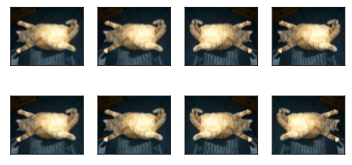

In [4]:
apply(img, mindspore.dataset.vision.RandomHorizontalFlip())

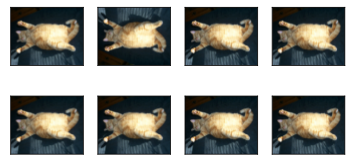

In [5]:
apply(img, mindspore.dataset.vision.RandomVerticalFlip())

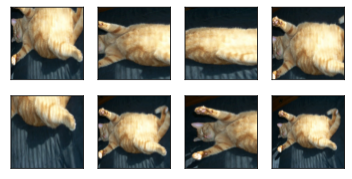

In [6]:
shape_aug = mindspore.dataset.vision.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 13.1.1.2. 改变颜色

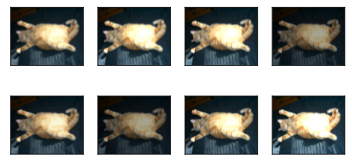

In [7]:
apply(img, mindspore.dataset.vision.RandomColorAdjust(
    brightness=0.5, contrast=0, saturation=0, hue=0))

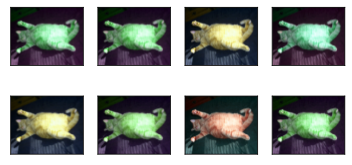

In [8]:
apply(img, mindspore.dataset.vision.RandomColorAdjust(
    brightness=0, contrast=0, saturation=0, hue=0.5))

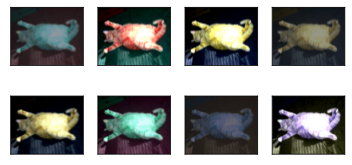

In [9]:
color_aug = mindspore.dataset.vision.RandomColorAdjust(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 13.1.1.3. 结合多种图像增广方法

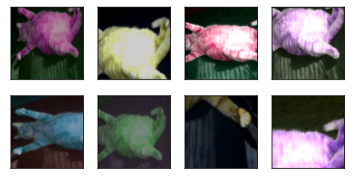

In [10]:
augs = mindspore.dataset.transforms.Compose([
    mindspore.dataset.vision.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 13.1.2. 使用图像增广进行训练

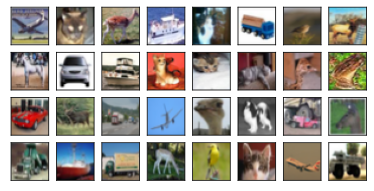

In [11]:
all_images = mindcv.create_dataset('cifar10',root="../data", split='train', 
                                   download=True).create_tuple_iterator()
d2l.show_images([next(all_images)[0] for i in range(32)], 4, 8, scale=0.8);

In [12]:
train_augs = mindspore.dataset.transforms.Compose([
     mindspore.dataset.vision.RandomHorizontalFlip(),
     mindspore.dataset.vision.ToTensor()])

test_augs = mindspore.dataset.transforms.Compose([
     mindspore.dataset.vision.ToTensor()])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    usage = 'train' if is_train else 'test'
    target_trans = mindspore.dataset.transforms.TypeCast(mindspore.dtype.int32)
    dataset = mindcv.create_dataset('cifar10',root="../data", split=usage, shuffle=is_train, download=True)
    dataset = dataset.map(augs, input_columns='image', num_parallel_workers=d2l.get_dataloader_workers())
    dataset = dataset.map(target_trans, input_columns='label', num_parallel_workers=d2l.get_dataloader_workers())
    dataset = dataset.batch(batch_size)

    return dataset

#### 13.1.2.1. 多GPU训练

In [14]:
def train_batch_ch13(train_step, X, y):
    """用多GPU进行小批量训练"""
    l, pred = train_step(X, y)
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), train_iter.get_dataset_size()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])

    def forward_fn(inputs, targets):
        logits = net(inputs)
        l = loss(logits, targets)
        return l, logits
    
    grad_fn = mindspore.value_and_grad(forward_fn, None, trainer.parameters, has_aux=True)
    
    def train_step(inputs, targets):
        (l, logits), grads = grad_fn(inputs, targets)
        trainer(grads)
        return l, logits
    
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        net.set_train()
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                train_step, features, labels) # , loss, trainer, devices
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

In [15]:
batch_size, net = 256, d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Dense, nn.Conv2d]:
        m.weight.set_data(mindspore.common.initializer.initializer('xavier_uniform', m.weight.shape))

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = nn.Adam(net.trainable_params(), learning_rate=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10)

train

In [ ]:
train_with_data_aug(train_augs, test_augs, net)